In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib
np.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


## Hierachical Gaussian Process Example
This is a simple example of a hierachical GP over a toy data set, the theory to do this is in  http://www.biomedcentral.com/1471-2105/14/252

Initially we generate a simple sinusoidal signal, which for our undertsanding is the parent signal.

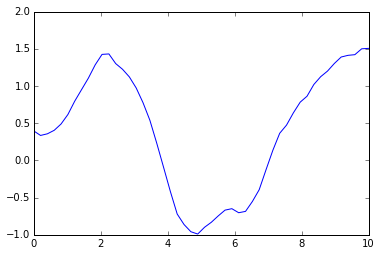

In [2]:
time_stamps = 50
x_parent = np.linspace(0, 10, time_stamps)
# generationg the parent form a GP sample
kg = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=3.0)
#inp = np.arange(x_parent.shape[0])
inp = x_parent[:, None]
C_parent_gen = kg.K(inp, None)
g_mean = np.zeros(x_parent.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
g_n = np.squeeze(g_n)
pb.plot(x_parent, g_n)

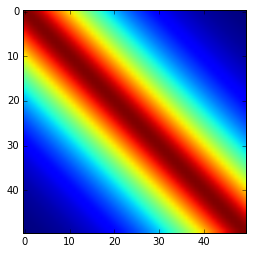

In [3]:
plt.imshow(C_parent_gen)

The we generate noise corrupted signals which are like "sons" from the original signal, to do this we only add to the original signal some  gaussian noise with mean zero and a standard deviation. We expect to recover the original signal using these as an input.

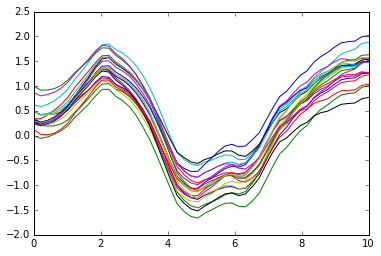

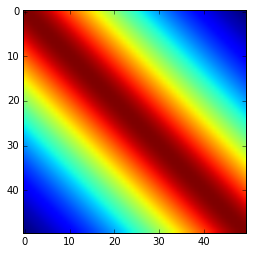

In [4]:
n_sons = 20
fn_list = []
kf = GPy.kern.Matern32(input_dim=1, variance=0.1, lengthscale=5.0)
C_sons_gen = kf.K(inp, None)
plt.figure(1)
for i in range(0, n_sons):
    tmp = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    tmp = np.squeeze(tmp)
    fn_list.append(tmp)
    plt.plot(inp, tmp)

plt.figure(2)
plt.imshow(C_sons_gen)

The samples can be also generated simultaneosly marginalizing out the parent

In [5]:
def genSamplesSimul(kg, kf, inp, n_sons=3):
    T_hat = np.r_[np.c_[inp, np.zeros_like(inp)]]
    for i in range(1,n_sons):
        T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*i]]
        
    HGP_gen = GPy.kern._src.independent_outputs.Hierarchical(kernels=[kg,kf])
    HGP_cov_gen = HGP_gen.K(T_hat, None)
    plt.figure(1)
    plt.imshow(HGP_cov_gen)
    sample = np.random.multivariate_normal(np.zeros(T_hat.shape[0]), HGP_cov_gen)
    y_list = []
    plt.figure(2)
    for r in range(0,n_sons):
        index = T_hat[:,1]==r
        y_list.append(sample[index])
        plt.plot(inp, sample[index])
    return y_list

Given the documentation, the way to consruct a Hierarchical Kernel to compute a hierarchical covariance one need to use GPy.kern._src.independent_outputs.Hierarchical(kernels), Which receives as an input a list of kernels, the size of that list indicates the deepest level of that hierarchy, for these case we only have one level or layer.

The input to the regression is:
* T_hat: all data in the input space as a column vector with an extra column indicating the corresponding output
* y_hat: all data in the output space(sinusoidal corrupted signal) as a column vector.
* HGP: Hierarchical Kernel

Documentation(Code): https://github.com/SheffieldML/GPy/blob/devel/GPy/kern/src/independent_outputs.py 

In [12]:
T_hat = np.r_[np.c_[inp, np.zeros_like(inp)]]
#fn_list = genSamplesSimul(kg, kf, inp, n_sons)
Y_hat = np.r_[np.c_[fn_list[0]]]
for i in range(1,n_sons):
    T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*i]]
    Y_hat = np.r_[Y_hat, np.c_[fn_list[i]]]
    
k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.) # Kernel for the underlying trend
k2 = GPy.kern.Matern32(1, variance=2., lengthscale=10.) #+ GPy.kern.White(1, variance=0.1) # Kernel for the layer of noise corrupted signals
#kernels = [k1,k2] 
HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels=[k1,k2])

In [13]:
model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
print 'Model before op', model
print 'hier kern before op', HGP
model.optimize('bfgs')#, messages=1)
print 'Model after op', model
print 'hier kern after op', HGP

Model before op 
Name                              : GP regression
Log-likelihood                    : -1088.56638993
Number of Parameters              : 5
Number of Optimization Parameters : 5
Updates                           : True
Parameters:
  GP_regression.                 |  Value  |  Constraint  |  Prior  |  Tied to
  hierarchy.Mat32_1.variance     |    5.0  |     +ve      |         |         
  hierarchy.Mat32_1.lengthscale  |   20.0  |     +ve      |         |         
  hierarchy.Mat32.variance       |    2.0  |     +ve      |         |         
  hierarchy.Mat32.lengthscale    |   10.0  |     +ve      |         |         
  Gaussian_noise.variance        |    1.0  |     +ve      |         |         
hier kern before op   hierarchy.           |  Value  |  Constraint  |  Prior  |  Tied to
  Mat32_1.variance     |    5.0  |     +ve      |         |         
  Mat32_1.lengthscale  |   20.0  |     +ve      |         |         
  Mat32.variance       |    2.0  |     +ve      |   

In [14]:
model.optimize_restarts(num_restarts = 20)

Optimization restart 1/20, f = -3061.07758613
Optimization restart 2/20, f = -3061.30949316
Optimization restart 3/20, f = -3053.00688304
Optimization restart 4/20, f = -3060.76626388
Optimization restart 5/20, f = -3060.67058931
Optimization restart 6/20, f = -3054.42059401
Optimization restart 7/20, f = -3060.18693236
Optimization restart 8/20, f = -3060.88437981
Optimization restart 9/20, f = -3061.43058326
Optimization restart 10/20, f = -3061.09347744
Optimization restart 11/20, f = -3061.26677393
Optimization restart 12/20, f = -2745.5551404
Optimization restart 13/20, f = -3061.07250136
Optimization restart 14/20, f = -3059.61146322
Optimization restart 15/20, f = -3058.31892911
Optimization restart 16/20, f = -3046.70287137
Optimization restart 17/20, f = -3046.56290251
Optimization restart 18/20, f = -3057.10673935
Optimization restart 19/20, f = -3047.18338539
Optimization restart 20/20, f = -3060.60543271


In [15]:
print k1
mu, mvar = model.predict(inp, kern=k1, full_cov=True)
#model.hierarchy.Mat32_1.variance = kg.variance
#model.hierarchy.Mat32_1.lengthscale = kg.lengthscale
#model.hierarchy.Mat32.variance = kf.variance
#model.hierarchy.Mat32.lengthscale = kf.lengthscale
print k1

  Mat32_1.     |      Value      |  Constraint  |  Prior  |  Tied to
  variance     |  1.05685673597  |     +ve      |         |         
  lengthscale  |  2.96014595153  |     +ve      |         |         
  Mat32_1.     |      Value      |  Constraint  |  Prior  |  Tied to
  variance     |  1.05685673597  |     +ve      |         |         
  lengthscale  |  2.96014595153  |     +ve      |         |         


We make the regression in order to obtain the optimal parameters for the covariance functions, then we obtain the approximated noise corrupted signals.

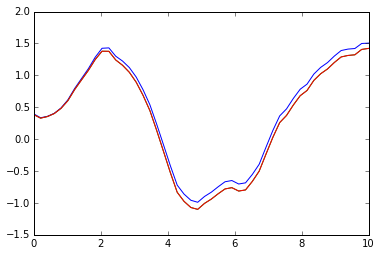

In [16]:
mu2, mvar2 = model.predict(inp, kern=k1, full_cov=True)
pb.plot(inp, g_n)
pb.plot(inp, mu)
pb.plot(inp, mu2)

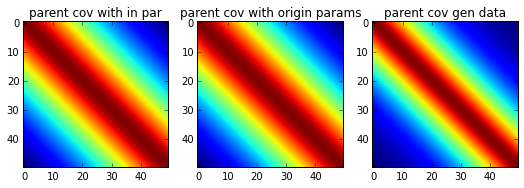

In [17]:
plt.figure(1, figsize=(12,6))
plt.subplot(1,4,1)
plt.title('parent cov with in par')
plt.imshow(mvar)
plt.subplot(1,4,2)
plt.title('parent cov with origin params')
plt.imshow(mvar2)
plt.subplot(1,4,3)
plt.title('parent cov gen data')
plt.imshow(C_parent_gen)


Name                              : GP regression
Log-likelihood                    : 2736.82989228
Number of Parameters              : 5
Number of Optimization Parameters : 5
Updates                           : True
Parameters:
  GP_regression.                 |        Value        |  Constraint  |  Prior  |  Tied to
  hierarchy.Mat32_1.variance     |      5.73161094328  |     +ve      |         |         
  hierarchy.Mat32_1.lengthscale  |      17.4365784313  |     +ve      |         |         
  hierarchy.Mat32.variance       |   0.00779616555405  |     +ve      |         |         
  hierarchy.Mat32.lengthscale    |      1.83060961355  |     +ve      |         |         
  Gaussian_noise.variance        |  1.47960036194e-07  |     +ve      |         |         


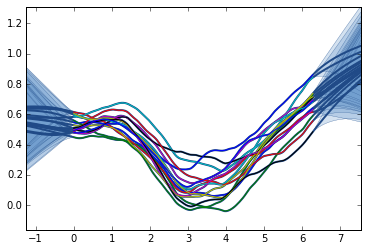

In [12]:
for i in range(n_sons):
        model.plot(fignum=1,fixed_inputs=[(1, i)], plot_raw=True)

for i in range(0, n_sons):
    pb.plot(inp, fn_list[i])

print model